## 利用KPCA进行异常检测

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import Model
from utils import *

# tf.config.experimental.list_physical_devices('CPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def pad_data(res, max_len=2850):
    length = len(res)
    if length > max_len:
        return res[ :max_len]
    elif length < max_len:
        return res + [0]*(max_len-length)
    return res


def train_data_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 2800]
        labels = labels[: 2800]
    elif mode == 'val':    
        codes = codes[2800: ]
        labels = labels[2800: ]

    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]
        
        
def train_data_loader(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 2800]
        labels = labels[: 2800]
    elif mode == 'val':    
        codes = codes[2800: ]
        labels = labels[2800: ]
    
    labels_res = np.eye(4)[labels]
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all), labels_res


def codes_loader(codes):
    
    res_all = []
    for idx in tqdm(range(len(codes))):
        fn = codes[idx]
        op_string = data_csv[data_csv.name == fn]
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        res_all.append(res)
    return np.array(res_all)


def codes_generator(codes):
    
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res
        
        
def svmdata_generator(codes, labels, mode):
    
    if mode == 'train':    
        codes = codes[: 2800]
        labels = labels[: 2800]
    elif mode == 'val':    
        codes = codes[2800: 663]
        labels = labels[2800: 663]
    
    labels_res = np.eye(4)[labels]
    for idx in range(len(codes)):
        fn = codes[idx]
        fn = bytes.decode(fn)
        op_string = data_csv[data_csv.name == fn]
        if len(op_string) == 0:
            print('null')
            continue
        op_string = op_string.iloc[0, 1].split()
        res = list(le.transform(op_string))
        res = pad_data(res)
        yield res, labels_res[idx]

In [3]:
# 利用labelencoder构建opcode编码器

from sklearn import preprocessing
from tqdm import tqdm

data_csv = pd.read_csv('res_handle.csv')
opcode_all = []
for idx in tqdm(range(data_csv.shape[0])):
    opcode_str = data_csv.at[idx, 'opcode'].split()
    opcode_all += opcode_str
    opcode_all = list(set(opcode_all))

le = preprocessing.LabelEncoder()
le.fit(opcode_all)
len(list(le.classes_))

100%|██████████| 12402/12402 [00:07<00:00, 1590.35it/s]


641

In [9]:
def res_testset(data_test, model_split, model_kPCA):
    # preprocess data
    ood2label = {True: 0, False: 1}
    codes_test = data_test['name'].to_list()
    labels_test = data_test['id'].map(lambda x: ood2label[x])
    labels_test = np.array(labels_test.to_list())
    codes_test = codes_loader(codes_test)

    layer_model = Model(inputs=model_split.input, outputs=model_split.layers[12].output)
    feature_test = layer_model.predict(codes_test)

    # kPCA anomaly detection
    test_scores = model_kPCA.decision_function(feature_test)
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, test_scores)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"roc_auc: {roc_auc}")

    print("histgram of test_scores from kPCA")
    scores_pd = pd.Series(test_scores)
    scores_pd.hist(bins=100)

    # plt roc curve and determine the threshold by youden index
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()
    index = np.argmax(tpr-fpr)
    score = thresholds[index]
    print(f"threshold: {score}") 

    # performance of textcnn after filtering out the samples
    for idx in range(len(test_scores)):
        if test_scores[idx] < score:
            data_test.at[idx, 'novelty'] = 0  # normal
        else:
            data_test.at[idx, 'novelty'] = 1  # abnormal

    data_normal = data_test[data_test['novelty']==0]
    print(data_normal.shape)

    # text_cnn模型performance
    from sklearn.metrics import classification_report

    codes_normal, labels_normal = name_loader(data_normal)
    codes_normal, labels_normal = train_data_loader(codes_normal, labels_normal, 'test')

    y_pred = model_split.predict(codes_normal)
    y_true = np.argmax(labels_normal, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    target_names = {'trojan', 'virus', 'worm', 'backdoor'}
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # performance of anomalty detection

    pca_pred = np.array(data_test['novelty'])
    pca_pred = pca_pred.astype('int64')
    ood2label = {True: 0, False: 1}
    label_id = np.array(data_test['id'].map(lambda x: ood2label[x]))
    print(classification_report(label_id, pca_pred, digits=4))

In [5]:
from methods.kpca import kPCA
from sklearn import metrics
import matplotlib.pyplot as plt

feature_train = np.load('feature_train.npy')
model_kPCA = kPCA(q = 50, sigma = 1.0985)
model_kPCA.fit(feature_train)

model_split = keras.models.load_model('./model/textcnn_split.h5')
data_test_1 = pd.read_csv('data_test_1.csv')
data_test_2 = pd.read_csv('data_test_2.csv')

100%|██████████| 1849/1849 [00:13<00:00, 137.36it/s]


roc_auc: 0.9261686108293485
histgram of test_scores from kPCA


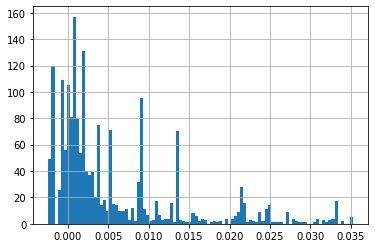

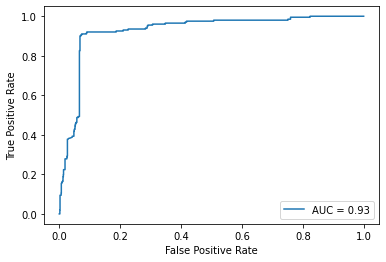

  2%|▏         | 31/1545 [00:00<00:04, 303.90it/s]

threshold: 0.011892470782566972
(1545, 7)


100%|██████████| 1545/1545 [00:11<00:00, 139.77it/s]


              precision    recall  f1-score   support

       virus     0.9749    0.9960    0.9853       506
      trojan     0.9923    1.0000    0.9961       514
    backdoor     0.9950    0.9900    0.9925       200
        worm     1.0000    0.9569    0.9780       325

    accuracy                         0.9883      1545
   macro avg     0.9905    0.9857    0.9880      1545
weighted avg     0.9885    0.9883    0.9883      1545

              precision    recall  f1-score   support

           0     0.9883    0.9266    0.9565      1648
           1     0.6020    0.9104    0.7248       201

    accuracy                         0.9248      1849
   macro avg     0.7952    0.9185    0.8406      1849
weighted avg     0.9463    0.9248    0.9313      1849



In [10]:
res_testset(data_test_1, model_split, model_kPCA)

100%|██████████| 1828/1828 [00:07<00:00, 243.27it/s]


roc_auc: 0.8606744329747019
histgram of test_scores from kPCA


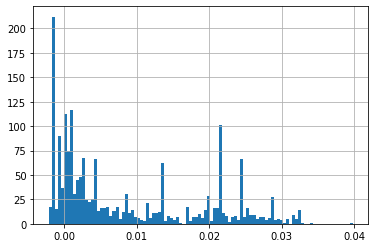

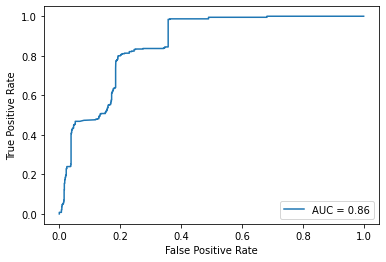

  2%|▏         | 15/936 [00:00<00:06, 150.00it/s]

threshold: 0.004199749403259706
(936, 7)


100%|██████████| 936/936 [00:03<00:00, 248.99it/s]


              precision    recall  f1-score   support

       virus     0.9895    0.9895    0.9895       286
      trojan     1.0000    1.0000    1.0000       204
    backdoor     0.9814    0.9814    0.9814       161
        worm     1.0000    1.0000    1.0000       285

    accuracy                         0.9936       936
   macro avg     0.9927    0.9927    0.9927       936
weighted avg     0.9936    0.9936    0.9936       936

              precision    recall  f1-score   support

           0     0.9936    0.6423    0.7802      1448
           1     0.4193    0.9842    0.5881       380

    accuracy                         0.7133      1828
   macro avg     0.7064    0.8132    0.6841      1828
weighted avg     0.8742    0.7133    0.7403      1828



In [11]:
res_testset(data_test_2, model_split, model_kPCA)